# Chat Data Analysis (WhatsApp Group)

### Data Collection

Data collected by exporting chat without media (format txt)

### Getting ready

Let us start setting up our enviroment so that we need to install required packages, libraries and so forth. 

In [1]:
!pip install emoji

In [2]:
!git clone https://github.com/amueller/word_cloud.git

fatal: destination path 'word_cloud' already exists and is not an empty directory.


In [3]:
!pip install wordcloud

In [4]:
!pip install regex

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex
import re
import emoji
import plotly.graph_objects as go
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

## Preparing Data

Firstly, we need to parse and tokenize plain text (txt) in order to deploy infromation in meaningful way. 

four tokens have been indentified: date, time, author and message:
{Date}{Time}{Author}{Message}

Example:
{01/01/2020}{9:00}{Javier}{Buenos días chicos, ¿como estáis?}
Therefore, parsing and tokenization functions have been developed as follows:

In [2]:
def startDateTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+) ([0-9]+):([0-9]+)[ ]?-'
    result = re.match(pattern,s)
    if result:
        return True
    return False

In [3]:
startDateTime('17/3/19 15:06 - Gabo: Hola')

True

In [4]:
def findAuthor(s):
    s = s.split(":")
    if len(s) == 2:
        return True
    else:
        return False

In [5]:
s = '17/3/19 15:06 - Gabo: Hola'
findAuthor(s)

False

In [6]:
def dataPoint(line):
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(' ')
    message = ' '.join(splitLine[1:])
    if findAuthor(message):
        splitMessage = message.split(': ')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [7]:
parsedData = []
cnvPath = 'Alicante.txt'
with open(cnvPath, encoding='utf-8') as fp:
    fp.readline()
    messageBuffer = []
    date, time, autor = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if startDateTime(line):
            if len(messageBuffer) > 0:
                parsedData.append([date, time, author,' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = dataPoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
            

In [8]:
df = pd.DataFrame(parsedData, columns = ['Date','Time','Author','Message'])
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
df.head(5)

Date   Time         Author                   Message
0 2019-05-26  18:14         Adrian                     Ummmm
1 2019-05-26  18:23  Marnie Peraza        Tengo unos vecinos
2 2019-05-26  18:23  Marnie Peraza            Son una pareja
3 2019-05-26  18:24  Marnie Peraza  Y siempre están peleando
4 2019-05-26  18:29           Gabo                    Esitos

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39997 entries, 0 to 39996
Data columns (total 4 columns):
Date       39997 non-null datetime64[ns]
Time       39997 non-null object
Author     39583 non-null object
Message    39997 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


### Data Visualization
Now, participating view is asked so that realize author's activity for each. 

In [11]:
df.Author.unique()

array(['Adrian', 'Marnie Peraza', 'Gabo', 'Damián', 'Javier', 'Herimar',
       'Maria Gabriela', None, 'Daniela Adrián', 'Jesus Marnie', 'Oriana'],
      dtype=object)

None: refers those messages that do not have authors, such as: 
 "Has sido añadido al grupo"
 or
 links added in the conversation

Removing None's messages

In [12]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39583 entries, 0 to 39996
Data columns (total 4 columns):
Date       39583 non-null datetime64[ns]
Time       39583 non-null object
Author     39583 non-null object
Message    39583 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB


In [13]:
df.Author.unique()

array(['Adrian', 'Marnie Peraza', 'Gabo', 'Damián', 'Javier', 'Herimar',
       'Maria Gabriela', 'Daniela Adrián', 'Jesus Marnie', 'Oriana'],
      dtype=object)

## Meaningful Stats

In [14]:
Total_msg = df.shape[0]
print(Total_msg)


39583


In [15]:
Media_msg = df[df['Message']== '<Multimedia omitido>'].shape[0]
print(Media_msg)

6748


In [16]:
def split_count(text):
    emoji_lst = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_lst.append(word)
    return emoji_lst
df["emoji"] = df["Message"].apply(split_count)

In [17]:
emojis = sum(df['emoji'].str.len())
print(emojis)

3086


In [18]:
URLpattern = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLpattern, x)).str.len()

In [19]:
links = np.sum(df.urlcount)
print(links)

39


In [20]:
print("Group Wise Stats")
print("Messages:",Total_msg)
print("Media:",Media_msg)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 39583
Media: 6748
Emojis: 3086
Links: 39


## Message Processing

In [21]:
Media_msg_df = df[df['Message'] == '<Multimedia omitido>']

msg_df = df.drop(Media_msg_df.index)

msg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32835 entries, 0 to 39995
Data columns (total 6 columns):
Date        32835 non-null datetime64[ns]
Time        32835 non-null object
Author      32835 non-null object
Message     32835 non-null object
emoji       32835 non-null object
urlcount    32835 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.8+ MB


Let's count the number of letters and words used by each author per message. To do so, 2 new columns have been added to the data frame as it follows:

In [22]:
msg_df['Letter_Count'] = msg_df['Message'].apply(lambda s : len(s))
msg_df['Word_Count'] = msg_df['Message'].apply(lambda s : len(s.split(' ')))
msg_df["MessageCount"]=1

In [23]:
msg_df.head(5)

Date   Time         Author                   Message emoji  urlcount  \
0 2019-05-26  18:14         Adrian                     Ummmm    []         0   
1 2019-05-26  18:23  Marnie Peraza        Tengo unos vecinos    []         0   
2 2019-05-26  18:23  Marnie Peraza            Son una pareja    []         0   
3 2019-05-26  18:24  Marnie Peraza  Y siempre están peleando    []         0   
4 2019-05-26  18:29           Gabo                    Esitos    []         0   

   Letter_Count  Word_Count  MessageCount  
0             5           1             1  
1            18           3             1  
2            14           3             1  
3            24           4             1  
4             6           1             1

In [24]:
msg_df["emojicount"]= df['emoji'].str.len()

In [25]:
msg_df.head(5)

Date   Time         Author                   Message emoji  urlcount  \
0 2019-05-26  18:14         Adrian                     Ummmm    []         0   
1 2019-05-26  18:23  Marnie Peraza        Tengo unos vecinos    []         0   
2 2019-05-26  18:23  Marnie Peraza            Son una pareja    []         0   
3 2019-05-26  18:24  Marnie Peraza  Y siempre están peleando    []         0   
4 2019-05-26  18:29           Gabo                    Esitos    []         0   

   Letter_Count  Word_Count  MessageCount  emojicount  
0             5           1             1           0  
1            18           3             1           0  
2            14           3             1           0  
3            24           4             1           0  
4             6           1             1           0

## Wise Stats by Author

In [26]:
l = msg_df.Author.unique()

for i in range(len(l)):
    req_df = msg_df[msg_df['Author']== l[i]]
    print(f'Stats of {l[i]} -')
    print('Messages sent', req_df.shape[0])
    words_per_msg = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message', words_per_msg)
    media = Media_msg_df[Media_msg_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent', media)
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent', emojis)
    links = sum(req_df["urlcount"])
    print('Links Sent', links)
    print()

Stats of Adrian -
Messages sent 1972
Words per message 3.7829614604462476
Media Messages Sent 343
Emojis Sent 86
Links Sent 0

Stats of Marnie Peraza -
Messages sent 8337
Words per message 5.22274199352285
Media Messages Sent 1064
Emojis Sent 942
Links Sent 2

Stats of Gabo -
Messages sent 4368
Words per message 4.192078754578755
Media Messages Sent 772
Emojis Sent 50
Links Sent 12

Stats of Damián -
Messages sent 3487
Words per message 3.659592773157442
Media Messages Sent 1378
Emojis Sent 197
Links Sent 2

Stats of Javier -
Messages sent 3605
Words per message 5.6502080443828016
Media Messages Sent 442
Emojis Sent 566
Links Sent 15

Stats of Herimar -
Messages sent 5702
Words per message 4.633637320238512
Media Messages Sent 1841
Emojis Sent 782
Links Sent 7

Stats of Maria Gabriela -
Messages sent 5312
Words per message 3.4679969879518073
Media Messages Sent 835
Emojis Sent 438
Links Sent 1

Stats of Daniela Adrián -
Messages sent 5
Words per message 7.0
Media Messages Sent 4
Emojis

## Emoji Stats

#### Unique and most used emojis

Unique emojis used

In [27]:
total_emojis_list = list(set([a for b in msg_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

341


Most used emojis

In [28]:
total_emojis_list = list([a for b in msg_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 311), ('🤣', 238), ('😆', 182), ('😭', 146), ('😅', 134), ('🤦🏻\u200d♀', 129), ('🥴', 93), ('🤔', 65), ('🥺', 53), ('😱', 52), ('🤦🏻\u200d♂', 50), ('🙃', 44), ('😢', 40), ('🌝', 40), ('🥳', 39), ('😘', 38), ('☺', 37), ('😎', 35), ('🙄', 32), ('🤤', 30), ('❤', 30), ('🤭', 28), ('🤷🏻\u200d♀', 26), ('🥰', 25), ('👀', 23), ('😍', 23), ('😞', 22), ('😊', 21), ('😟', 20), ('😩', 20), ('💃🏻', 19), ('🤪', 18), ('🧟\u200d♀', 18), ('🐑', 17), ('😔', 17), ('😒', 16), ('😴', 15), ('🤷🏻\u200d♀️', 15), ('👍🏻', 14), ('👺', 14), ('👇🏻', 14), ('🥵', 14), ('😕', 13), ('😑', 13), ('😇', 13), ('💸', 13), ('🤦🏻\u200d♀️', 13), ('😋', 12), ('🙋🏻', 11), ('😏', 11), ('🙌🏻', 10), ('👌🏻', 10), ('💕', 10), ('😥', 10), ('🤷🏻\u200d♂', 10), ('🐹', 10), ('🤗', 10), ('⚠️', 10), ('⭐', 9), ('🙆🏻', 9), ('😈', 9), ('😪', 9), ('😡', 9), ('🎅🏻', 9), ('👩\u200d\U0001f9bc', 9), ('💩', 8), ('✨', 8), ('🤟🏻', 8), ('🤓', 8), ('😤', 8), ('🤮', 8), ('😐', 8), ('😬', 7), ('👻', 7), ('💙', 7), ('😨', 7), ('📸', 7), ('🐌', 7), ('🤫', 7), ('☹️', 7), ('☹', 6), ('🙆🏻\u200d♀', 6), ('😓', 6), ('😮', 6), ('🧐

In [29]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(11)

emoji  count
0      😂    311
1      🤣    238
2      😆    182
3      😭    146
4      😅    134
5   🤦🏻‍♀    129
6      🥴     93
7      🤔     65
8      🥺     53
9      😱     52
10  🤦🏻‍♂     50

#### Emoji distribution

In [30]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## WordCloud

In [31]:
text = " ".join(review for review in msg_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 793900 words in all the messages.


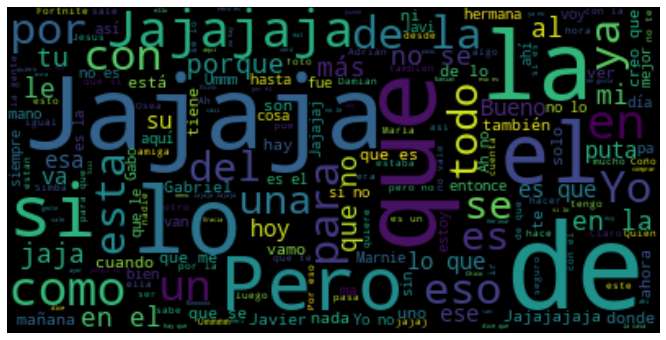

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
    
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### By Author

Author name Adrian


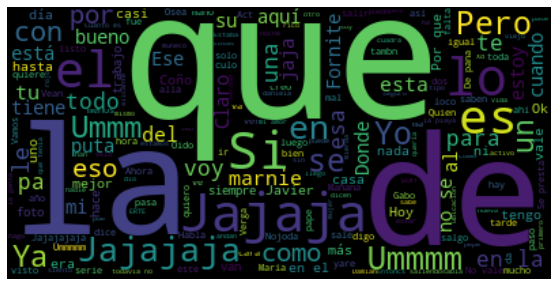

Author name Marnie Peraza


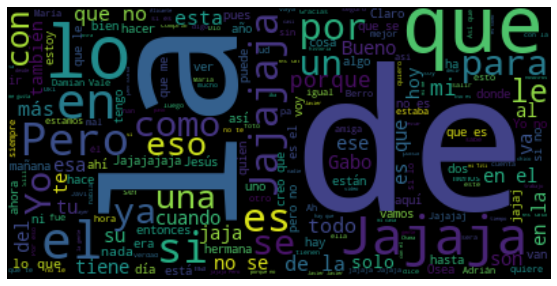

Author name Gabo


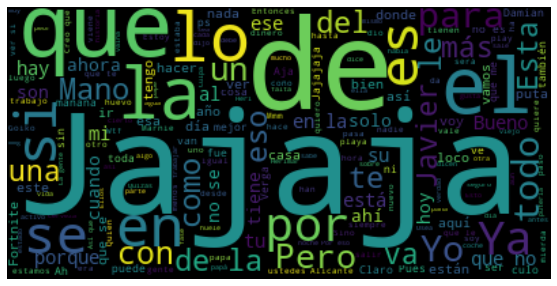

Author name Damián


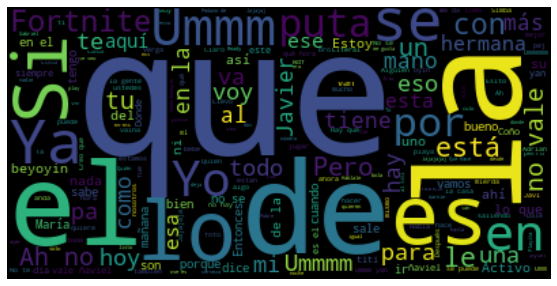

Author name Javier


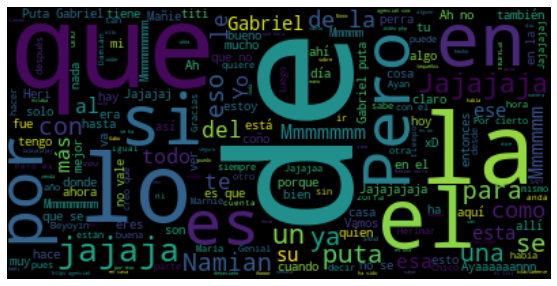

Author name Herimar


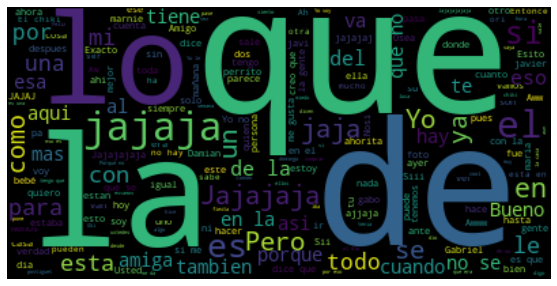

Author name Maria Gabriela


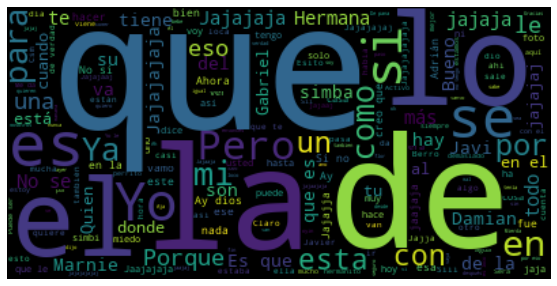

Author name Daniela Adrián


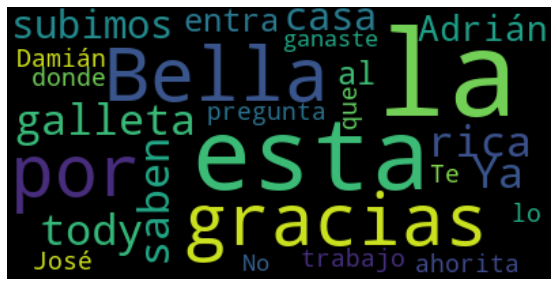

Author name Jesus Marnie


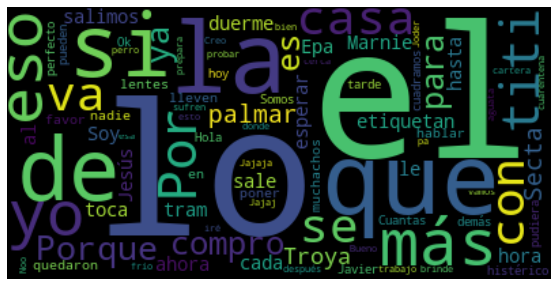

Author name Oriana


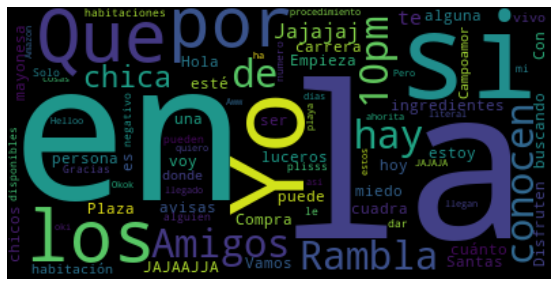

In [33]:
l = msg_df.Author.unique()
for i in range(len(l)):
    dummy_df = msg_df[msg_df['Author'] == l[i]]
    text = " ".join(review for review in dummy_df.Message)
    stopwords = set(STOPWORDS)
    print('Author name',l[i])
    wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Final Stats
### Group most active Day and hour

Day Distribution

In [34]:
def f(i):
    l=["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday","Sunday"]
    return l[i];
day_df=pd.DataFrame(msg_df["Message"])
day_df['day_date'] = msg_df['Date'].dt.weekday
day_df['day_date'] = day_df['day_date'].apply(f)
day_df['MessageCount'] = 1
day = day_df.groupby("day_date").sum()
day.reset_index(inplace=True)

In [35]:
fig = px.line_polar(day, r='MessageCount', theta='day_date', line_close=True)
fig.update_traces(fill="toself")
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
        )),
    showlegend=False
)
fig.show()

In [122]:
date_df = msg_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [123]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

### When are member most active?

Top 10

Text(0, 0.5, 'Time')

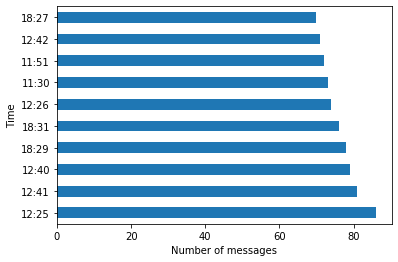

In [124]:
msg_df['Time'].value_counts().head(10).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Time')

### Most active day

2019-07-20    450
2019-02-06    358
2019-01-06    342
2019-08-11    335
2020-06-14    333
             ... 
2020-02-29      2
2019-06-06      2
2020-06-07      2
2019-08-07      2
2020-01-03      1
Name: Date, Length: 414, dtype: int64


Text(0, 0.5, 'Date')

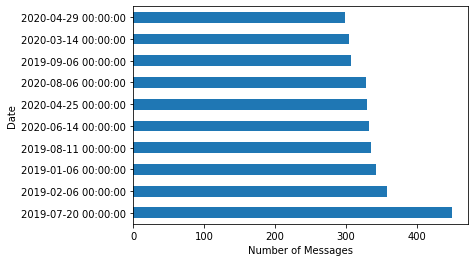

In [125]:
msg_df['Date'].value_counts().head(10).plot.barh()
print(msg_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')